In [254]:
import os

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")
from misc.tools import random_stochastic_matrix, normalize_rows
from game.perception import generate_sim_matrix, generate_dist_matrix
from misc.util import encoders_to_df
from misc.vis import basic_encoder_heatmap

In [255]:
torch.set_printoptions(sci_mode=False)

In [256]:
u = 3 # world states
m = 2 # meaning distributions
shape = (m, u)

universe = list(range(u))
dist = generate_dist_matrix(universe)
sim = generate_sim_matrix(universe, 1e0, dist) # (u, u) matrix

print(sim)

# NOTE: How should we construct the (m, u) matrix? 
# In general this is a deep empirical question about what the categories are that humans form to represent a domain. 
# The answer essentially tells us what the unsupervised classification/clustering algorithm is for humans/agents for a particular domain, which is nontrivial to obtain.

# When m = u, modeling is easy, and we can make the simplifying assumption of creating a similarity based matrix, and since there's no information loss from u to m, we don't need to make a decision about how to cluster objects into meanings.

# M = random_stochastic_matrix(shape, 1e0)
# M = torch.Tensor([[0.5, 0.3, 0.2], [0., 0.1, 0.9]])
M = normalize_rows(sim)
print()

print(M)
print(M.T)
print()

print(M @ M.T)
print(normalize_rows(M @ M.T))

tensor([[1.0000, 0.3679, 0.0183],
        [0.3679, 1.0000, 0.3679],
        [0.0183, 0.3679, 1.0000]])

tensor([[0.7214, 0.2654, 0.0132],
        [0.2119, 0.5761, 0.2119],
        [0.0132, 0.2654, 0.7214]])
tensor([[0.7214, 0.2119, 0.0132],
        [0.2654, 0.5761, 0.2654],
        [0.0132, 0.2119, 0.7214]])

tensor([[0.5910, 0.3086, 0.0895],
        [0.3086, 0.4217, 0.3086],
        [0.0895, 0.3086, 0.5910]])
tensor([[0.5975, 0.3120, 0.0905],
        [0.2970, 0.4059, 0.2970],
        [0.0905, 0.3120, 0.5975]])


In [257]:
heatmap = lambda enc: basic_encoder_heatmap(encoders_to_df(torch.stack([enc])))

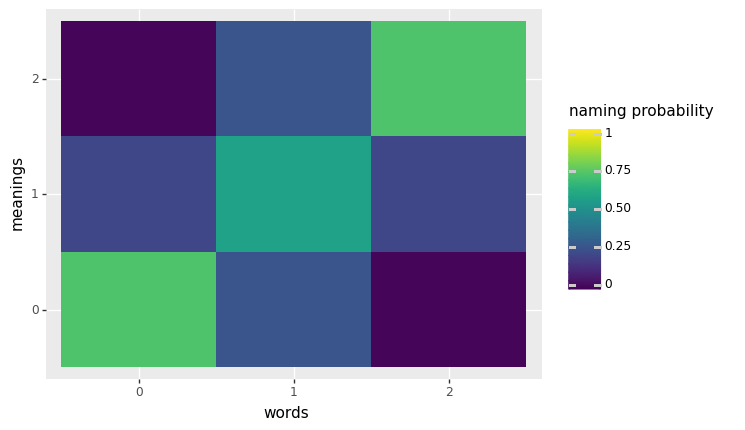

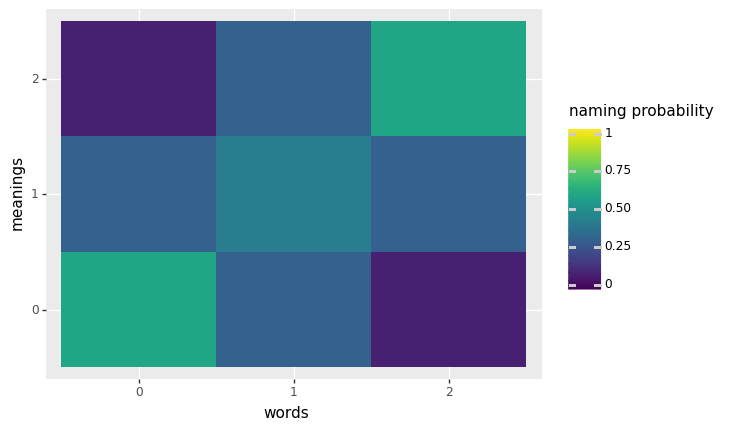

In [258]:
print(heatmap(M))
print(heatmap(M @ M.T))

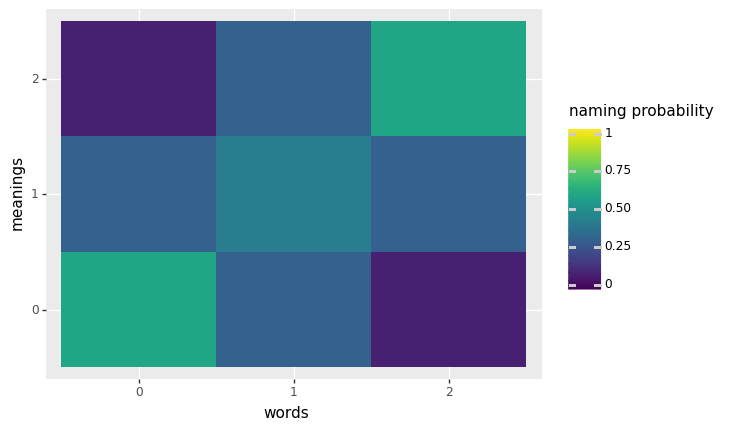

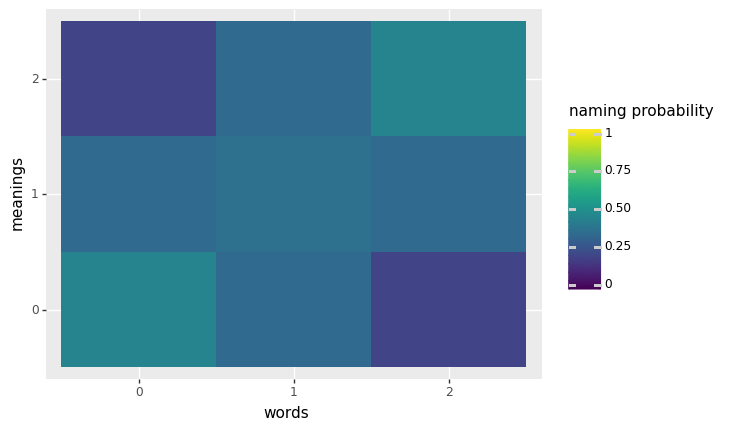

In [259]:
# iterate confusion
M = M @ M.T

print(heatmap(M))
print(heatmap(M @ M.T))

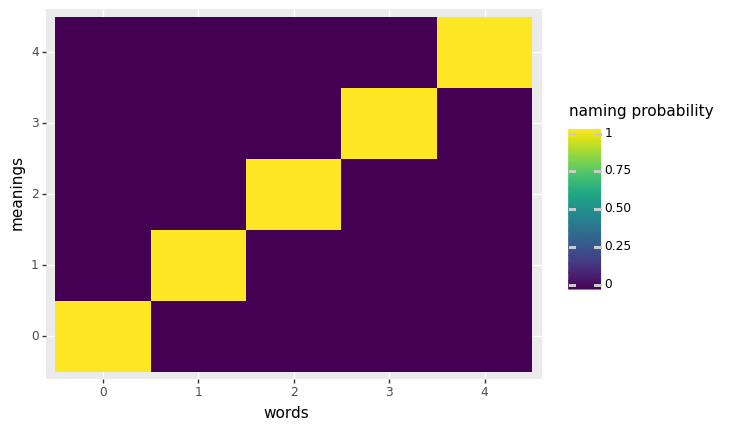

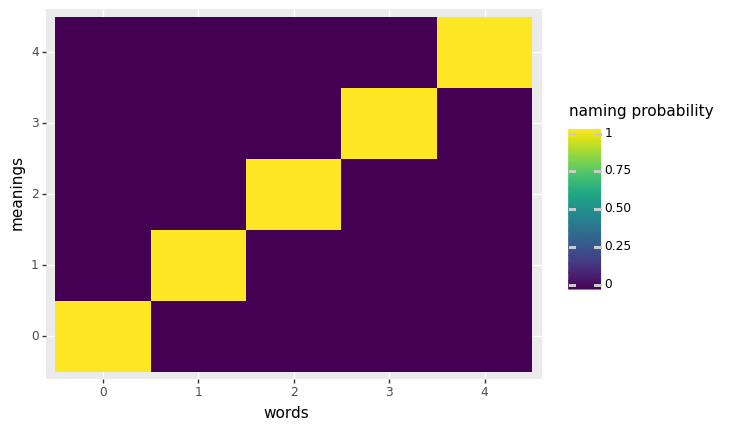

In [260]:
# check out gaussian noise
x = torch.eye(5)
# std = 0 # even if this is 0, you don't get back the id function, because you're running through softmax
# m = x + torch.randn(5) * (std ** 0.5)
# m = torch.softmax(m, dim=-1)
# m = torch.softmax(x, dim=-1)
m = x / x.sum(dim=-1, keepdim=True)

print(heatmap(x))
print(heatmap(m))

In [ ]:
# So clearly, gaussian noise is out of the question as the regularizing matrix, since we'll have to run softmax to normalize to dist again, and at that point we might as well just use energy based distribution, since it's no longer really gaussian.

# What about the meaning distributions? Well, some of the values will have to be truncated, because when the Gaussian noise is added to a point on the edge of the meaning space, we obtain values outside the meaning space. But if we truncate those values, our perceptual uncertainty function is no longer Gaussian. 

# The reason it's important to be strict about Gaussian vs not, is that Tucker et al formally prove the upper bound on the decoder as squared error. Of course, any objective that's not KL distortion will be an upper bound on the distortion, right? So for simplicity the move might be to stick with energy-based distribution.